In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
import albumentations as A
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

#Обработка данных

In [ ]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(10)

In [ ]:
#Cобираv информацию о директориях и путях к файлам для дальнейшей обработки в пандас
# Проходим по всем поддиректориям в указанном пути, иИзвлекаем имя текущей директории
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        # Извлекаем имя текущей директории
        dir_name = sub_dir_path.split('/')[-1]
        # Проходим по всем файлам в текущей директории
        for filename in os.listdir(sub_dir_path):
            # Формируем полный путь к файлу,  добавляем информацию о директории и файле в список
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head(-1)

patient_id                                               path
0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...                     ...                                                ...
7852  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7853  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

[7857 rows x 2 columns]

In [ ]:
df.head(-1)

In [ ]:
#Заводим Датафреймы с пустями с маской и без
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 89
END_IMG_LEN = 4 # .tiff
END_MASK_LEN = 9 # _mask.tiff
# Сортируем изображния и маски по айди пациента
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_18.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_18_mask.tif


In [ ]:
#Создаем итоговый датасет для дальнейшей работы, проверям пустая ли маска и расставляем соответственно метки
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 4 columns]

In [ ]:
brain_df['mask'].value_counts()

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


#Визуализация

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,
                        y=brain_df['mask'].value_counts(),
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split
#Разбиваем выборку на обучающую и тестовую
train, test = train_test_split(brain_df_train, test_size=0.15)
#Для сгментации нужны только изображения с маскми
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape
#Создам валидационную выборку
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

# Создаем списки путей к изображениям и маскам для каждого набора
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [ ]:
class DataGenerator0(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 8, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]
    X, y = self.__data_generation(list_ids, list_mask)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))
    for i in range(len(list_ids)):
      img_path = str(list_ids[i])
      mask_path = str(list_mask[i])
      img = io.imread(img_path)
      mask = io.imread(mask_path)
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
#Центрируем и нормализуем изображения и маски
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)
      img -= img.mean()
      img /= img.std()

      mask -= mask.mean()
      mask /= mask.std()
      X[i,] = img
      y[i,] = np.expand_dims(mask, axis = 2)
    y = (y > 0).astype(int)

    return X, y



In [ ]:
train_data = DataGenerator0(train_ids, train_mask)
val_data = DataGenerator0(val_ids, val_mask)

In [ ]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
from sklearn import metrics

In [ ]:
pip install keras_preprocessing

  Obtaining dependency information for keras_preprocessing from https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

#Cегментационные функции потерь и метрики

In [ ]:
from keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable


epsilon = 1e-5
smooth = 1
@register_keras_serializable()
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.2
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def dice_loss(y_true, y_pred):
    import tensorflow as tf

# Преобразуем y_true к типу данных y_pred для совместимости
    y_true = tf.cast(y_true, y_pred.dtype)

# Выполняем поэлементное умножение
    smooth = 0.2
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred) + smooth
    return 1 - (numerator + 1 + smooth) / (denominator + 1 + smooth)

import tensorflow as tf
from keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


#Работа с гиперпараметрами

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Add

def conv_block(inputs, filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def res_block(inputs, filters):
    x = conv_block(inputs, filters)
    x = conv_block(x, filters)
    residual = conv_block(inputs, filters) #shortcut projection
    x = Add()([x, residual])
    #x = Dropout(0.1)(x)
    x = Activation('relu')(x)
    return x

def upsample_concat_block_0(up_tensor, skip_tensor):
    upsampled = UpSampling2D((2, 2))(up_tensor)
    concatenated = Concatenate()([upsampled, skip_tensor])
    return concatenated


In [ ]:
from tensorflow.keras.layers import Conv2DTranspose

def upsample_concat_block(up_tensor, skip_tensor, filters=None):
    filters = filters if filters is not None else up_tensor.shape[-1] // 2
    upsampled = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(up_tensor)
    concatenated = Concatenate()([upsampled, skip_tensor])
    return concatenated

In [ ]:
def build_resunet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = conv_block(inputs, 16)
    conv1 = conv_block(conv1, 16)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = res_block(pool1, 32)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = res_block(pool2, 64)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = res_block(pool3, 128)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = res_block(pool4, 256)

    # Expanding Path
    up6 = upsample_concat_block(conv5, conv4)
    conv6 = res_block(up6, 128)

    up7 = upsample_concat_block(conv6, conv3)
    conv7 = res_block(up7, 64)

    up8 = upsample_concat_block(conv7, conv2)
    conv8 = res_block(up8, 32)

    up9 = upsample_concat_block(conv8, conv1)
    conv9 = res_block(up9, 16)

    # Output Layer
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model


model_resunet = build_resunet()
#model_resunet.summary()


In [ ]:
def build_resunet_5(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = conv_block(inputs, 16)
    conv1 = conv_block(conv1, 16)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = res_block(pool1, 32)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = res_block(pool2, 64)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = res_block(pool3, 128)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = res_block(pool4, 256)
    pool5 = MaxPool2D(pool_size=(2, 2))(conv5)

    conv6 = res_block(pool5, 512)
    pool5 = MaxPool2D(pool_size=(2, 2))(conv5)

     # Bottleneck
        conv6 = res_block(pool5, 512)
    # Expanding Path

    up7 = upsample_concat_block(conv6, conv5)
    conv7 = res_block(up7, 256)

    up8 = upsample_concat_block(conv7, conv4)
    conv8 = res_block(up8, 128)

    up9 = upsample_concat_block(conv8, conv3)
    conv9 = res_block(up9, 64)

    up10 = upsample_concat_block(conv9, conv2)
    conv10 = res_block(up10, 32)

    up11 = upsample_concat_block(conv10, conv1)
    conv11 = res_block(up11, 16)

    # Output Layer
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv11)

    model = Model(inputs=inputs, outputs=output)
    return model


model_resunet = build_resunet_5()
#model_resunet.summary()


In [ ]:
def build_resunet_10(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = conv_block(inputs, 16)
    conv1 = conv_block(conv1, 16)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = res_block(pool1, 32)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = res_block(pool2, 64)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = res_block(pool3, 128)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = res_block(pool4, 256)
    pool5 = MaxPool2D(pool_size=(2, 2))(conv5)

    conv6 = res_block(pool5, 512)
    pool6 = MaxPool2D(pool_size=(2, 2))(conv6)

    # Bottleneck
    conv7 = res_block(pool6, 1024)

    # Expanding Path

    up8 = upsample_concat_block(conv7, conv6)
    conv8 = res_block(up8, 512)

    up9 = upsample_concat_block(conv8, conv5)
    conv9 = res_block(up9, 256)

    up10 = upsample_concat_block(conv9, conv4)
    conv10 = res_block(up10, 128)

    up11 = upsample_concat_block(conv10, conv3)
    conv11 = res_block(up11, 64)

    up12 = upsample_concat_block(conv11, conv2)
    conv12 = res_block(up12, 32)

    up13 = upsample_concat_block(conv12, conv1)
    conv13 = res_block(up13, 16)

    # Output Layer
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv13)

    model = Model(inputs=inputs, outputs=output)
    return model

# Create the ResUNet model
model_resunet = build_resunet_10()
#model_resunet.summary()


In [ ]:
model_resunet = build_resunet()
#model_resunet.summary()
adam = tf.keras.optimizers.Adam(lr = 0.005, epsilon = 0.1)
model_resunet.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )

earlystopping = EarlyStopping(monitor='tversy',
                              mode='max',
                              verbose=1,
                              patience=10,
                              restore_best_weights=True
                             )

checkpointer = ModelCheckpoint(filepath="model_resunet0.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_tversky',
                              mode='max',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
h1 = model_resunet.fit(train_data,
                  epochs = 120,
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/120
145/145 [==============================] - ETA: 0s - loss: 0.9555 - tversky: 0.0588
Epoch 1: val_loss improved from inf to 0.95488, saving model to model_resunet0.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/145 [==============================] - 73s 357ms/step - loss: 0.9555 - tversky: 0.0588 - val_loss: 0.9549 - val_tversky: 0.0597 - lr: 0.0010
Epoch 2/120
145/145 [==============================] - ETA: 0s - loss: 0.9352 - tversky: 0.0854
Epoch 2: val_loss improved from 0.95488 to 0.93260, saving model to model_resunet0.hdf5
145/145 [==============================] - 21s 147ms/step - loss: 0.9352 - tversky: 0.0854 - val_loss: 0.9326 - val_tversky: 0.0887 - lr: 0.0010
Epoch 3/120
145/145 [==============================] - ETA: 0s - loss: 0.9197 - tversky: 0.1055
Epoch 3: val_loss improved from 0.93260 to 0.91661, saving model to model_resunet0.hdf5
145/145 [==============================] - 15s 101ms/step - loss: 0.9197 - tversky: 0.1055 - val_loss: 0.9166 - val_tversky: 0.1095 - lr: 0.0010
Epoch 4/120
145/145 [==============================] - ETA: 0s - loss: 0.9014 - tversky: 0.1291
Epoch 4: val_loss improved from 0.91661 to 0.89454, saving model to model_resunet0.hdf5
145/145 [====

In [ ]:
model_resunet_json = model_resunet0.to_json()
with open("model_resunet91_json.json", "w") as json_file:
    json_file.write(model_resunet_json)

h1.history.keys()

In [ ]:
model_resunet.save('/kaggle/working/resunet91.keras')

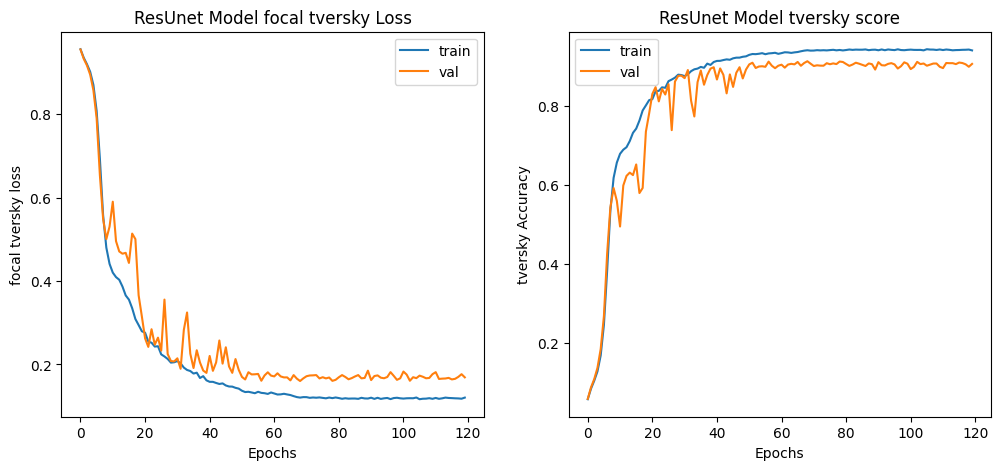

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h1.history['loss']);
plt.plot(h1.history['val_loss']);
plt.title("ResUnet Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h1.history['tversky']);
plt.plot(h1.history['val_tversky']);
plt.title("ResUnet Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator0(test_ids, test_mask)
_, tv = model_resunet.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))


12/12 [==============================] - 5s 128ms/step - loss: 0.1245 - tversky: 0.9373
Segmentation tversky is 93.73%


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
y_true_flat = true_labels
y_pred_flat = predicted_labels

#Вычисляем метрики
precision = precision_score(y_true_flat, y_pred_flat, average='binary')
recall = recall_score(y_true_flat, y_pred_flat, average='binary')
f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')
dice = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'IoU: {iou:.4f}')
print(f'Dice Coefficient: {dice:.4f}')


Precision: 1.0000
Recall: 0.9792
F1-score: 0.9895
IoU: 0.9792
Dice Coefficient: 0.9895


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
def adjust_data(img, mask):
    #img = img / 255.0
    #mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask
#Применияем аугмнтацию
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids , mask, image_dir='./', batch_size=16, img_h=256, img_w=256, shuffle=True):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentor = ImageDataGenerator(
             rotation_range=0.02,
             width_shift_range=0.02,
             height_shift_range=0.02,
            # brightness_range=[0.95, 1],
            # horizontal_flip=True,
             vertical_flip=True,
             shear_range=0.01,
             zoom_range=0.01,
             fill_mode='nearest'
        )

    def __len__(self):
        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_ids = [self.ids[i] for i in indexes]
        list_mask = [self.mask[i] for i in indexes]
        X, y = self.__data_generation(list_ids, list_mask)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        for i in range(len(list_ids)):
            img_path = str(list_ids[i])
            mask_path = str(list_mask[i])
            img = io.imread(img_path)
            mask = io.imread(mask_path, as_gray=True)
            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)
            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)
            img -= img.mean()
            img /= img.std()
            mask -= mask.mean()
            mask /= mask.std()
            X[i,] = img
            y[i,] = np.expand_dims(mask, axis=2)
        y = (y > 0).astype(int)


        for i in range(len(X)):
            seed = 42 )
            X[i] = self.augmentor.random_transform(X[i], seed=seed)
            y[i] = self.augmentor.random_transform(y[i], seed=seed)
            X[i], y[i] = adjust_data(X[i], y[i])  # Бинаризуем маски
        return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)


#Предсказание наличия опухоли и ее контура

In [ ]:
def prediction(test, model, model_seg):
    mask, image_id, has_mask = [], [], []
    for i in test.image_path:

        img = io.imread(i)
        img = img *1./255.
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1,256,256,3))
        is_defect = model.predict(img)
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue

        X = np.empty((1,256,256,3))
        img = io.imread(i)
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)

        img -= img.mean()
        img /= img.std()
        X[0,] = img

        predict = model_seg.predict(X)

        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
df_pred = prediction(test, model456, model_resunet)
df_pred

1/1 [==============================] - 0s 28ms/step


image_path  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
..                                                 ...   
585  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
586  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
587  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
588  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
589  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                        predicted_mask  has_mask  
0                                           No mask :)         0  
1                                           No mask :)         0  
2    [[[[1.08885615e-05], [2.9152168e-05], [2.19460...         1  
3                                           No mask :)         0  
4    [[[[1.2634341e-05], [2.5532767e-05], [1.828098...         1  
..                                                 ...       ...  
585  [[[[9.868728e-06], [3.242078e-05], [2.3633414e...         1  
586                                         No mask :)         0  
587  [[[[1.7533515e-05], [2.5084892e-05], [2.763824...         1  
588                                         No mask :)         0  
589  [[[[1.1744143e-05], [2.4324956e-05], [1.826636...         1  

[590 rows x 3 columns]

In [ ]:
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path mask  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   

                                      predicted_mask  has_mask  
0                                         No mask :)         0  
1                                         No mask :)         0  
2  [[[[1.08885615e-05], [2.9152168e-05], [2.19460...         1  
3                                         No mask :)         0  
4  [[[[1.2634341e-05], [2.5532767e-05], [1.828098...         1  
5                                         No mask :)         0  
6                                         No mask :)         0  
7                                         No mask :)         0  
8  [[[[8.287878e-06], [5.2856525e-05], [1.5473186...         1  
9                                         No mask :)         0

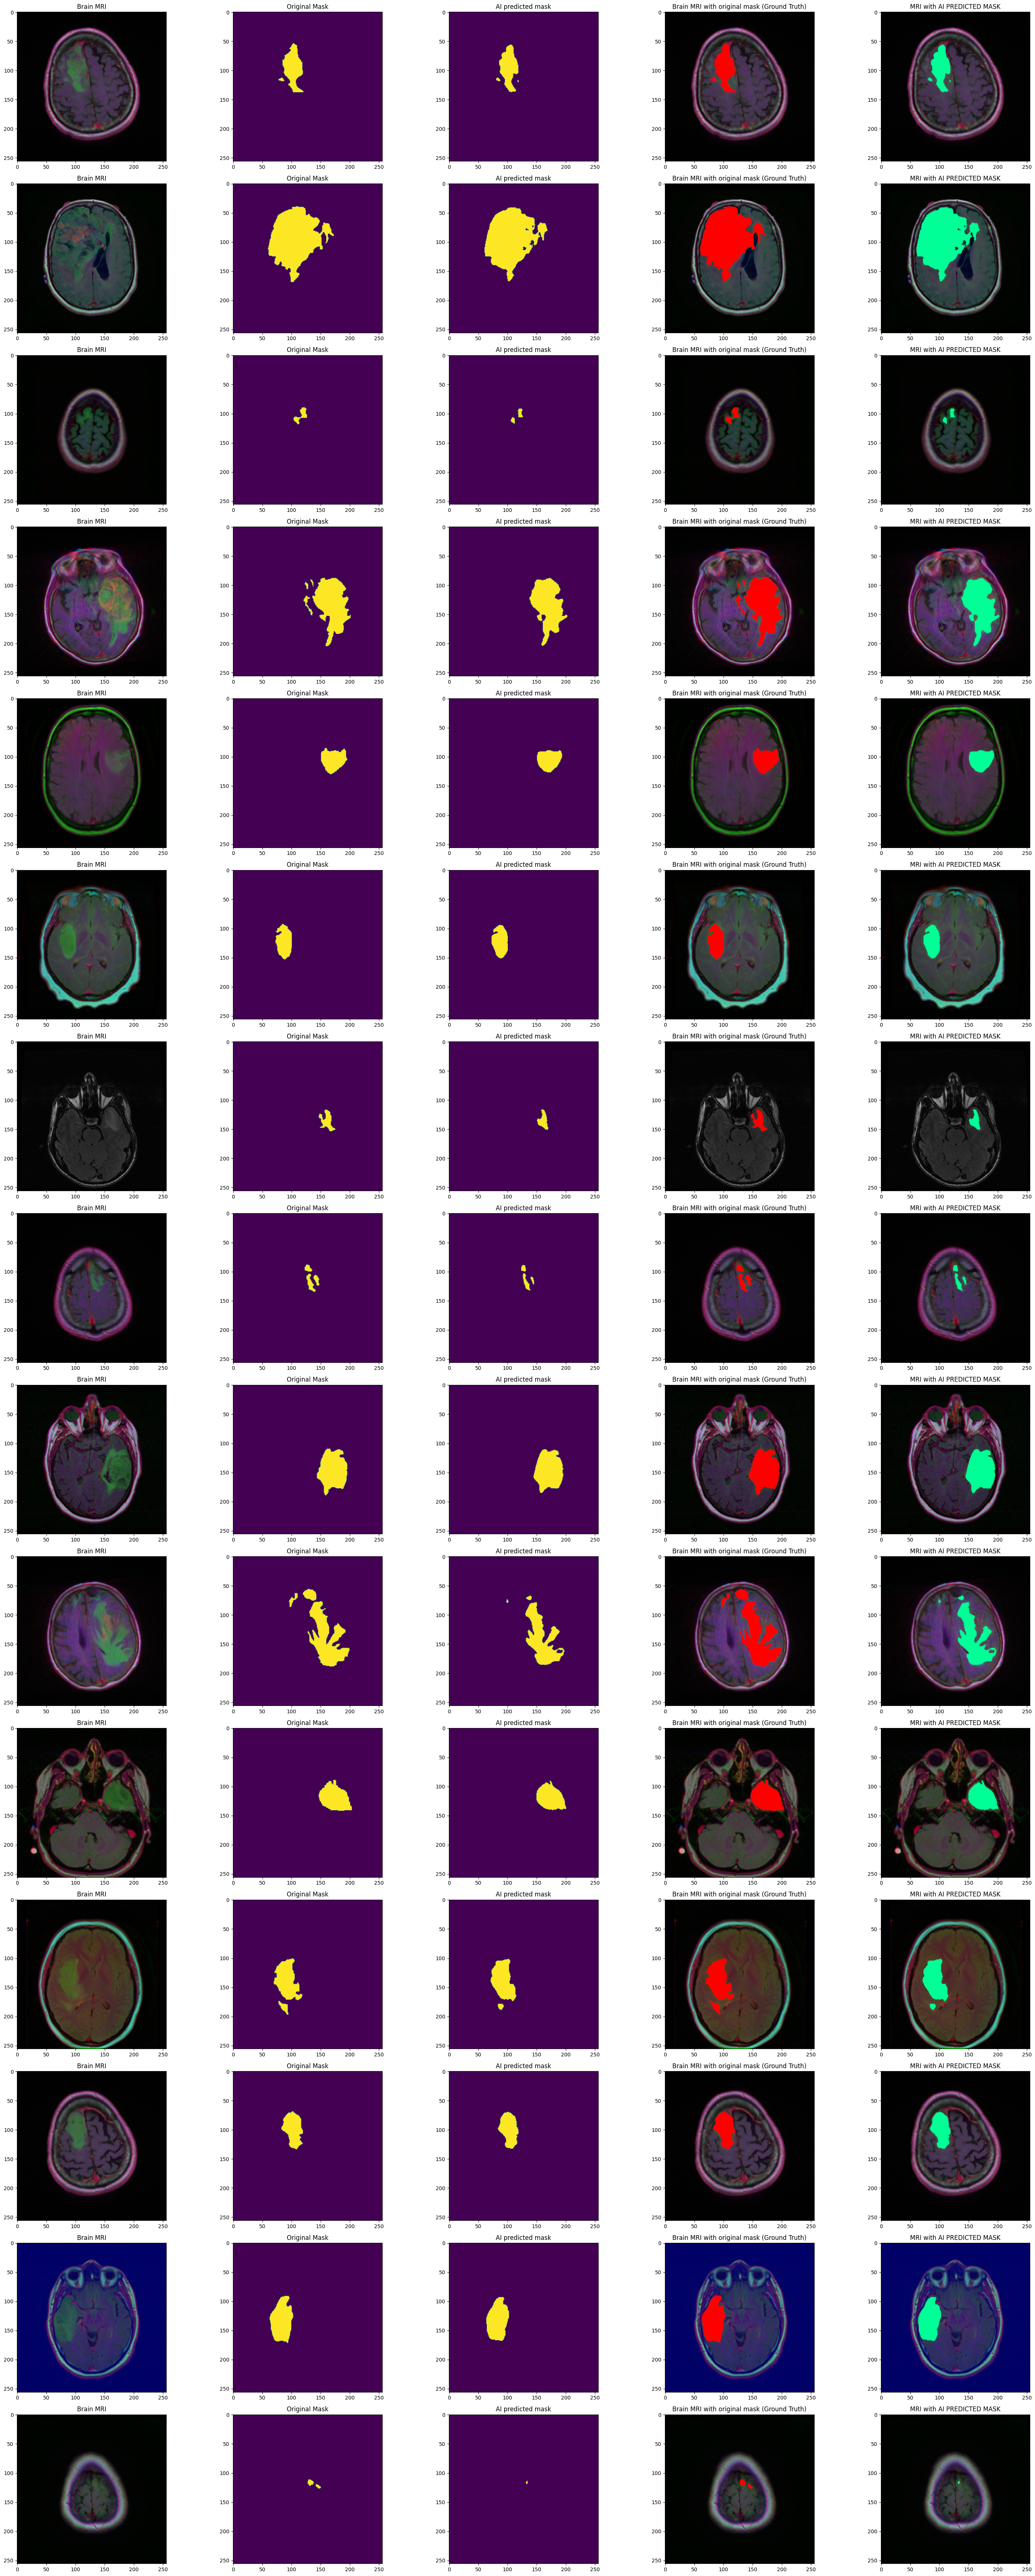

In [ ]:
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')

        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')

        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')

        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')

        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')

        count +=1
    if (count==15):
        break

fig.tight_layout()